### A few initial libraries ###

In [1]:
import numpy as np
import qiskit
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile

from qiskit.transpiler import PassManager

from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer, plot_histogram
from qiskit.compiler import assemble
from qiskit.tools.monitor import job_monitor

from qiskit import IBMQ
from qiskit.test.mock import FakeManhattan
from qiskit.test.mock import FakeBogota
from qiskit.test.mock import FakeMumbai
from qiskit.test.mock import FakeTokyo
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.pulse import PulseSystemModel
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview

import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import NoiseModel

from gate_variants.toffoli_variants import CCX_Variant_Gate 
from orientation_map import orientation_map_gen

from backends.backend_connectivity import cluster, couplingmap_to_graph, orientation_from_coupling

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

from trios_bench.cnx_dirty import generate_dirty_multicontrol
from trios_bench.cnx_halfdirty import generate_cnx_halfdirty
from trios_bench.cnx_logdepth import generate_cnx_log_depth
from trios_bench.cnx_inplace import generate_cnx_inplace
from trios_bench.cuccaro_adder import generate_cuccaro_adder
from trios_bench.Takahashi_adder import generate_takahashi_adder
from trios_bench.incrementer_borrowedbit import generate_incrementer
from trios_bench.grovers_integer_search import generate_grover_integer_search_circuit
from trios_bench.qaoa import generate_random_QAOA
from trios_bench.sym6 import generate_sym6
from trios_bench.sym9 import generate_sym9

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/qiskit-terra/lib/python3.7/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.18.3', 'qiskit-aer': '0.9.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.18.1', 'qiskit-aqua': '0.9.5', 'qiskit': '0.32.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [3]:
def cluster(k_inner, k_outer):
    coupling_map = []
    qid = 0
    for i in range(0, k_inner):
        for j in range(0, k_outer):
            qid = k_outer * i + j
            for j2 in range(0, k_outer):
                if j != j2:
                    coupling_map.append([qid, k_outer * i + j2])
                
        for i2 in range(0, k_inner):
            if i != i2:
                coupling_map.append([i*k_outer, i2*k_outer])

    return coupling_map

In [4]:
coupling_map = cluster(4, 5)

In [5]:
coupling_map

[[0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [1, 0],
 [1, 2],
 [1, 3],
 [1, 4],
 [2, 0],
 [2, 1],
 [2, 3],
 [2, 4],
 [3, 0],
 [3, 1],
 [3, 2],
 [3, 4],
 [4, 0],
 [4, 1],
 [4, 2],
 [4, 3],
 [0, 5],
 [0, 10],
 [0, 15],
 [5, 6],
 [5, 7],
 [5, 8],
 [5, 9],
 [6, 5],
 [6, 7],
 [6, 8],
 [6, 9],
 [7, 5],
 [7, 6],
 [7, 8],
 [7, 9],
 [8, 5],
 [8, 6],
 [8, 7],
 [8, 9],
 [9, 5],
 [9, 6],
 [9, 7],
 [9, 8],
 [5, 0],
 [5, 10],
 [5, 15],
 [10, 11],
 [10, 12],
 [10, 13],
 [10, 14],
 [11, 10],
 [11, 12],
 [11, 13],
 [11, 14],
 [12, 10],
 [12, 11],
 [12, 13],
 [12, 14],
 [13, 10],
 [13, 11],
 [13, 12],
 [13, 14],
 [14, 10],
 [14, 11],
 [14, 12],
 [14, 13],
 [10, 0],
 [10, 5],
 [10, 15],
 [15, 16],
 [15, 17],
 [15, 18],
 [15, 19],
 [16, 15],
 [16, 17],
 [16, 18],
 [16, 19],
 [17, 15],
 [17, 16],
 [17, 18],
 [17, 19],
 [18, 15],
 [18, 16],
 [18, 17],
 [18, 19],
 [19, 15],
 [19, 16],
 [19, 17],
 [19, 18],
 [15, 0],
 [15, 5],
 [15, 10]]

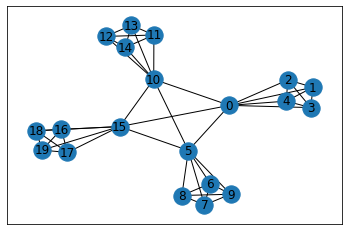

In [6]:
couplingmap_to_graph(coupling_map, Draw=True)

In [7]:
orientation_map = orientation_from_coupling(coupling_map)

### Load device and the device configuration object ###

In [9]:
IBMQ.load_account()

provider = IBMQ.get_provider('ibm-q-ornl')
# device = FakeMumbai()

# backend_prop = device.properties()

In [10]:
from qiskit_superstaq.superstaq_provider import SuperstaQProvider

In [11]:
superstaq_provider = SuperstaQProvider(api_key="ya29.A0ARrdaM-BWPjpkjhKgbVSRwWROaVE3g6mKCew2all4yXuPNLIwc6l65K10DiAMa-w8he0mR-i0Tb_jE6-GqqWlscj9Zq58rC2oSSzRVaLdZJMoy2bWqIXVhK3Tehp5N4zd8uHhyp01G9KC90Xmu3BKALiGiLP-w")

In [12]:
from level3_context import _parse_transpile_args, level_3_context_pass_manager
from level3_context_pulse import level_3_swap_pulse_pass_manager, level_3_pass_manager, level_3_orign_pulse_pass_manager, level_3_context_pulse_pass_manager, level_3_pulse_pass_manager

In [13]:
qc_test = qiskit.circuit.QuantumCircuit(10)
qc_test.x(0)
qc_test.cx(0,1)
qc_test.swap(0,1)
qc_test.cx(2,1)
qc_test.swap(1,2)

In [14]:
qc_test.draw()

┌───┐                
q_0: ┤ X ├──■───X─────────
     └───┘┌─┴─┐ │ ┌───┐   
q_1: ─────┤ X ├─X─┤ X ├─X─
          └───┘   └─┬─┘ │ 
q_2: ───────────────■───X─
                          
q_3: ─────────────────────
                          
q_4: ─────────────────────
                          
q_5: ─────────────────────
                          
q_6: ─────────────────────
                          
q_7: ─────────────────────
                          
q_8: ─────────────────────
                          
q_9: ─────────────────────

In [19]:
pm_orign = level_3_pass_manager(pass_manager_config)
qc_orign = pm_orign.run(qc_test)

layout_method:  dense
routing method:  basic


In [21]:
qc_orign.draw()

global phase: 5π/4
                ┌────┐┌──────────┐        ┌────┐  ┌──────────┐┌────┐     »
       q_0 -> 0 ┤ √X ├┤ Rz(-π/2) ├──■─────┤ √X ├──┤ Rz(-π/2) ├┤ √X ├──■──»
                ├───┬┘├──────────┤┌─┴─┐┌──┴────┴─┐└──────────┘└────┘┌─┴─┐»
       q_1 -> 1 ┤ X ├─┤ Rz(-π/2) ├┤ X ├┤ Rz(π/2) ├──────────────────┤ X ├»
                └───┘ └──────────┘└───┘└─────────┘                  └───┘»
       q_2 -> 2 ─────────────────────────────────────────────────────────»
                                                                         »
       q_3 -> 3 ─────────────────────────────────────────────────────────»
                                                                         »
       q_4 -> 4 ─────────────────────────────────────────────────────────»
                                                                         »
       q_5 -> 5 ─────────────────────────────────────────────────────────»
                                                                         »
       q_6 -> 6 ─────────────────────────────────────────────────────────»
                                                                         »
       q_7 -> 7 ─────────────────────────────────────────────────────────»
                                                                         »
       q_8 -> 8 ─────────────────────────────────────────────────────────»
                                                                         »
       q_9 -> 9 ─────────────────────────────────────────────────────────»
                                                                         »
ancilla_0 -> 10 ─────────────────────────────────────────────────────────»
                                                                         »
ancilla_1 -> 11 ─────────────────────────────────────────────────────────»
                                                                         »
ancilla_2 -> 12 ─────────────────────────────────────────────────────────»
                                                                         »
ancilla_3 -> 13 ─────────────────────────────────────────────────────────»
                                                                         »
ancilla_4 -> 14 ─────────────────────────────────────────────────────────»
                                                                         »
ancilla_5 -> 15 ─────────────────────────────────────────────────────────»
                                                                         »
ancilla_6 -> 16 ─────────────────────────────────────────────────────────»
                                                                         »
ancilla_7 -> 17 ─────────────────────────────────────────────────────────»
                                                                         »
ancilla_8 -> 18 ─────────────────────────────────────────────────────────»
                                                                         »
ancilla_9 -> 19 ─────────────────────────────────────────────────────────»
                                                                         »
«                  ┌────┐  ┌────────┐                
«       q_0 -> 0 ──┤ √X ├──┤ Rz(-π) ├────────────────
«                ┌─┴────┴─┐└─┬────┬─┘┌─────────┐┌───┐
«       q_1 -> 1 ┤ Rz(-π) ├──┤ √X ├──┤ Rz(π/2) ├┤ X ├
«                └────────┘  └────┘  └─────────┘└─┬─┘
«       q_2 -> 2 ─────────────────────────────────■──
«                                                    
«       q_3 -> 3 ────────────────────────────────────
«                                                    
«       q_4 -> 4 ────────────────────────────────────
«                                                    
«       q_5 -> 5 ────────────────────────────────────
«                                                    
«       q_6 -> 6 ────────────────────────────────────
«                                                    
«       q_7 -> 7 ────────────────────────────────────
«                                         

In [22]:
pm_swap = level_3_swap_pulse_pass_manager(pass_manager_config)
qc_swap = pm_swap.run(qc_test)

layout_method:  dense
routing method:  basic
intersect [Qubit(QuantumRegister(20, 'q'), 1)]
intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 1)]
two intersection conditions True True
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')


In [24]:
qc_swap.draw()

global phase: 3π/4
                  ┌───┐   ┌─────────┐          ┌───────────┐┌──────────┐┌────┐»
       q_0 -> 0 ──┤ X ├───┤ Rz(π/2) ├──────────┤1          ├┤ Rz(-π/2) ├┤ √X ├»
                ┌─┴───┴──┐└──┬────┬─┘┌────────┐│  Acecr_pm │└┬────────┬┘├────┤»
       q_1 -> 1 ┤ Rz(-π) ├───┤ √X ├──┤ Rz(-π) ├┤0          ├─┤ Rz(-π) ├─┤ √X ├»
                └─┬───┬──┘┌──┴────┴─┐└────────┘└───────────┘ └────────┘ └────┘»
       q_2 -> 2 ──┤ X ├───┤ Rz(π/2) ├─────────────────────────────────────────»
                  └───┘   └─────────┘                                         »
       q_3 -> 3 ──────────────────────────────────────────────────────────────»
                                                                              »
       q_4 -> 4 ──────────────────────────────────────────────────────────────»
                                                                              »
       q_5 -> 5 ──────────────────────────────────────────────────────────────»
                                                                              »
       q_6 -> 6 ──────────────────────────────────────────────────────────────»
                                                                              »
       q_7 -> 7 ──────────────────────────────────────────────────────────────»
                                                                              »
       q_8 -> 8 ──────────────────────────────────────────────────────────────»
                                                                              »
       q_9 -> 9 ──────────────────────────────────────────────────────────────»
                                                                              »
ancilla_0 -> 10 ──────────────────────────────────────────────────────────────»
                                                                              »
ancilla_1 -> 11 ──────────────────────────────────────────────────────────────»
                                                                              »
ancilla_2 -> 12 ──────────────────────────────────────────────────────────────»
                                                                              »
ancilla_3 -> 13 ──────────────────────────────────────────────────────────────»
                                                                              »
ancilla_4 -> 14 ──────────────────────────────────────────────────────────────»
                                                                              »
ancilla_5 -> 15 ──────────────────────────────────────────────────────────────»
                                                                              »
ancilla_6 -> 16 ──────────────────────────────────────────────────────────────»
                                                                              »
ancilla_7 -> 17 ──────────────────────────────────────────────────────────────»
                                                                              »
ancilla_8 -> 18 ──────────────────────────────────────────────────────────────»
                                                                              »
ancilla_9 -> 19 ──────────────────────────────────────────────────────────────»
                                                                              »
«                           ┌───────────┐    ┌───┐    ┌─────────┐
«       q_0 -> 0 ───────────┤1          ├────┤ X ├────┤ Rz(π/2) ├
«                ┌─────────┐│  Acecr_pm │┌───┴───┴───┐└─────────┘
«       q_1 -> 1 ┤ Rz(π/2) ├┤0          ├┤1          ├───────────
«                └─────────┘└───────────┘│  Acecr_pm │           
«       q_2 -> 2 ────────────────────────┤0          ├───────────
«                                        └───────────┘           
«       q_3 -> 3 ────────────────────────────────────────────────
«                                                                
«       q_4 -> 4 ────────────────────────────────────────────────
«                                        

In [25]:
qc0 = generate_dirty_multicontrol(6, 11)
qc1 = generate_cnx_halfdirty(19)
qc2 = generate_cnx_log_depth(19)
qc3 = generate_cnx_inplace(4)
qc4 = generate_cuccaro_adder(20)
qc5 = generate_takahashi_adder(20)
qc6 = generate_incrementer(5)
qc7 = generate_grover_integer_search_circuit(6, 3, 0, maxn=None, num_rounds=None)
qc8 = generate_random_QAOA(10, 0.6, 2)
qc9 = generate_sym6()
qc10 = generate_sym9()
qc_list = [qc0, qc1, qc2, qc3, qc4, qc5,qc6, qc7 , qc8, qc9, qc10]

In [ ]:
#orientation_map = orientation_map_gen(backend)

In [16]:
#coupling_map = [[0, 1], [1, 0], [1, 2], [1, 4], [2, 1], [2, 3], [3, 2], [3, 5], [4, 1], [4, 7], [5, 3], [5, 8], [6, 7], [7, 4], [7, 6], [7, 10], [8, 5], [8, 9], [8, 11], [9, 8], [10, 7], [10, 12], [11, 8], [11, 14], [12, 10], [12, 13], [12, 15], [13, 12], [13, 14], [14, 11], [14, 13], [14, 16], [15, 12], [15, 18], [16, 14], [16, 19], [17, 18], [18, 15], [18, 17], [18, 21], [19, 16], [19, 20], [19, 22], [20, 19], [21, 18], [21, 23], [22, 19], [22, 25], [23, 21], [23, 24], [24, 23], [24, 25], [25, 22], [25, 24], [25, 26], [26, 25]]

In [28]:
transpile_args = _parse_transpile_args(qc_list, backend = None, coupling_map = coupling_map, basis_gates = ['cx', 'rz', 'sx', 'x', 'acecr_pm'], seed_transpiler = 0, orientation_map = orientation_map)

In [29]:
pass_manager_config = transpile_args[0]['pass_manager_config']

In [30]:
def generate_results(qc, pass_config):
    pm_orign = level_3_pass_manager(pass_manager_config)
    pm_orign_pulse = level_3_orign_pulse_pass_manager(pass_manager_config)
    pm_context = level_3_context_pass_manager(pass_manager_config)
    pm_context_pulse = level_3_context_pulse_pass_manager(pass_manager_config)
    pm_swap_pulse = level_3_swap_pulse_pass_manager(pass_manager_config)
    qc_orign = pm_orign.run(qc)
    qc_orign_pulse = pm_orign_pulse.run(qc)
    qc_context = pm_context.run(qc)
    qc_context_pulse = pm_context_pulse.run(qc)
    qc_swap_pulse = pm_swap_pulse.run(qc)
    return [qc_orign, qc_orign_pulse, qc_context, qc_context_pulse, qc_swap_pulse]

In [31]:
result_lists = []
for qc in qc_list:
    result_lists.append(generate_results(qc, pass_manager_config))

layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
Layout({
18: Qubit(QuantumRegister(18, 'q'), 7),
15: Qubit(QuantumRegister(18, 'q'), 8),
0: Qubit(QuantumRegister(18, 'q'), 9),
2: Qubit(QuantumRegister(18, 'q'), 10),
10: Qubit(QuantumRegister(18, 'q'), 3),
16: Qubit(QuantumRegister(18, 'q'), 0),
17: Qubit(QuantumRegister(18, 'q'), 1),
19: Qubit(QuantumRegister(18, 'q'), 2),
3: Qubit(QuantumRegister(18, 'q'), 4),
4: Qubit(QuantumRegister(18, 'q'), 5),
1: Qubit(QuantumRegister(18, 'q'), 6),
9: Qubit(QuantumRegister(18, 'q'), 11),
7: Qubit(QuantumRegister(18, 'q'), 12),
6: Qubit(QuantumRegister(18, 'q'), 13),
8: Qubit(QuantumRegister(18, 'q'), 14),
14: Qubit(QuantumRegister(18, 'q'), 15),
11: Qubit(QuantumRegister(18, 'q'), 16),
13: Qubit(QuantumRegiste

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
Layout({
18: Qubit(QuantumRegister(18, 'q'), 7),
15: Qubit(QuantumRegister(18, 'q'), 8),
0: Qubit(QuantumRegister(18, 'q'), 9),
2: Qubit(QuantumRegister(18, 'q'), 10),
10: Qubit(QuantumRegister(18, 'q'), 3),
16: Qubit(QuantumRegister(18, 'q'), 0),
17: Qubit(QuantumRegister(18, 'q'), 1),
19: Qubit(QuantumRegister(18, 'q'), 2),
3: Qubit(QuantumRegister(18, 'q'), 4),
4: Qubit(QuantumRegister(18, 'q'), 5),
1: Qubit(QuantumRegister(18, 'q'), 6),
9: Qubit(QuantumRegister(18, 'q'), 11),
7: Qubit(QuantumRegister(18, 'q'), 12),
6: Qubit(QuantumRegister(18, 'q'), 13),
8: Qubit(QuantumRegister(18, 'q'), 14),
14: Qubit(QuantumRegister(18, 'q'), 15),
11: Qubit(QuantumRegister(18, 'q'), 16),
13: Qubit(QuantumRegister(18, 'q'), 17)
})
The physical qubits for the toffoli are:  2 4 1
The required toffoli will be decomposed using a 6 cnot decomposition
three intersection conditions False True True
three qargs Qubit(QuantumRegister(20, 'q'),

('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'b')
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 4)]
intersect [Qubit(QuantumRegister(20, 'q'), 2)]
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 2), Qubit(QuantumRegister(20, 'q'), 1)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 1)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 2)]
('00', '11', 'b')
('11', '00', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 15)]
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 15), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 18)]
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 18), Qubit(QuantumRegister(

('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'b')
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 4)]
intersect [Qubit(QuantumRegister(20, 'q'), 2)]
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 2), Qubit(QuantumRegister(20, 'q'), 1)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 1)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 2)]
('00', '11', 'b')
('11', '00', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 15)]
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 15), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 18)]
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 18), Qubit(QuantumRegister(

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
No solution found:  call limit reached
Layout({
14: Qubit(QuantumRegister(19, 'q'), 0),
13: Qubit(QuantumRegister(19, 'q'), 1),
12: Qubit(QuantumRegister(19, 'q'), 2),
11: Qubit(QuantumRegister(19, 'q'), 3),
9: Qubit(QuantumRegister(19, 'q'), 4),
8: Qubit(QuantumRegister(19, 'q'), 5),
7: Qubit(QuantumRegister(19, 'q'), 6),
6: Qubit(QuantumRegister(19, 'q'), 7),
4: Qubit(QuantumRegister(19, 'q'), 8),
3: Qubit(QuantumRegister(19, 'q'), 9),
2: Qubit(QuantumRegister(19, 'q'), 10),
1: Qubit(QuantumRegister(19, 'q'), 11),
10: Qubit(QuantumRegister(19, 'q'), 12),
5: Qubit(QuantumRegister(19, 'q'), 13),
0: Qubit(QuantumRegister(19, 'q'), 14),
15: Qubit(QuantumRegister(19, 'q'), 15),
17: Qubit(QuantumRegister(19, 'q'), 16),
16: Qubit(QuantumRegister(19, 'q'), 17),
18: Qubit(QuantumRegister(19, 'q'), 18)
})
The physical qubits for the toffoli are:  0 3 2
The required to

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
No solution found:  call limit reached
Layout({
14: Qubit(QuantumRegister(19, 'q'), 0),
13: Qubit(QuantumRegister(19, 'q'), 1),
12: Qubit(QuantumRegister(19, 'q'), 2),
11: Qubit(QuantumRegister(19, 'q'), 3),
9: Qubit(QuantumRegister(19, 'q'), 4),
8: Qubit(QuantumRegister(19, 'q'), 5),
7: Qubit(QuantumRegister(19, 'q'), 6),
6: Qubit(QuantumRegister(19, 'q'), 7),
4: Qubit(QuantumRegister(19, 'q'), 8),
3: Qubit(QuantumRegister(19, 'q'), 9),
2: Qubit(QuantumRegister(19, 'q'), 10),
1: Qubit(QuantumRegister(19, 'q'), 11),
10: Qubit(QuantumRegister(19, 'q'), 12),
5: Qubit(QuantumRegister(19, 'q'), 13),
0: Qubit(QuantumRegister(19, 'q'), 14),
15: Qubit(QuantumRegister(19, 'q'), 15),
17: Qubit(QuantumRegister(19, 'q'), 16),
16: Qubit(QuantumRegister(19, 'q'), 17),
18: Qubit(QuantumRegister(19, 'q'), 18)
})
The physical qubits for the toffoli are:  0 3 2
The required to

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
No solution found:  call limit reached
Layout({
14: Qubit(QuantumRegister(19, 'q'), 0),
13: Qubit(QuantumRegister(19, 'q'), 1),
12: Qubit(QuantumRegister(19, 'q'), 2),
11: Qubit(QuantumRegister(19, 'q'), 3),
9: Qubit(QuantumRegister(19, 'q'), 4),
8: Qubit(QuantumRegister(19, 'q'), 5),
7: Qubit(QuantumRegister(19, 'q'), 6),
6: Qubit(QuantumRegister(19, 'q'), 7),
4: Qubit(QuantumRegister(19, 'q'), 8),
3: Qubit(QuantumRegister(19, 'q'), 9),
2: Qubit(QuantumRegister(19, 'q'), 10),
1: Qubit(QuantumRegister(19, 'q'), 11),
10: Qubit(QuantumRegister(19, 'q'), 12),
5: Qubit(QuantumRegister(19, 'q'), 13),
0: Qubit(QuantumRegister(19, 'q'), 14),
15: Qubit(QuantumRegister(19, 'q'), 15),
17: Qubit(QuantumRegister(19, 'q'), 16),
16: Qubit(QuantumRegister(19, 'q'), 17),
18: Qubit(QuantumRegister(19, 'q'), 18)
})
The physical qubits for the toffoli are:  0 3 2
The required to

intersect [Qubit(QuantumRegister(20, 'q'), 6), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 6)]
('11', '00', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 9)]
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 18), Qubit(QuantumRegister(20, 'q'), 15)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 18), Qubit(QuantumRegister(20, 'q'), 15)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 15), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 15)]
intersect [Qubit(QuantumRegister(20, 'q'), 0)]
('11', '00', 'f')
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 3)]
intersect [Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 16), Qubit(QuantumRegister(20, 'q'), 15)]
('00', '11', 'f')
('11', '00', 'b')
interse

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
No solution found:  call limit reached
Layout({
14: Qubit(QuantumRegister(19, 'q'), 0),
13: Qubit(QuantumRegister(19, 'q'), 1),
12: Qubit(QuantumRegister(19, 'q'), 2),
11: Qubit(QuantumRegister(19, 'q'), 3),
9: Qubit(QuantumRegister(19, 'q'), 4),
8: Qubit(QuantumRegister(19, 'q'), 5),
7: Qubit(QuantumRegister(19, 'q'), 6),
6: Qubit(QuantumRegister(19, 'q'), 7),
4: Qubit(QuantumRegister(19, 'q'), 8),
3: Qubit(QuantumRegister(19, 'q'), 9),
2: Qubit(QuantumRegister(19, 'q'), 10),
1: Qubit(QuantumRegister(19, 'q'), 11),
10: Qubit(QuantumRegister(19, 'q'), 12),
5: Qubit(QuantumRegister(19, 'q'), 13),
0: Qubit(QuantumRegister(19, 'q'), 14),
15: Qubit(QuantumRegister(19, 'q'), 15),
17: Qubit(QuantumRegister(19, 'q'), 16),
16: Qubit(QuantumRegister(19, 'q'), 17),
18: Qubit(QuantumRegister(19, 'q'), 18)
})
The physical qubits for the toffoli are:  0 3 2
The required to

look for variant_rules ('00', '02', 'f', 's')
final tag, one match ('10', '02', 'f', 'p')
look for variant_rules ('00', '00', 'f', 'p')
didn't find match tag
intersect [Qubit(QuantumRegister(20, 'q'), 6), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 6)]
('11', '00', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 9)]
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 18), Qubit(QuantumRegister(20, 'q'), 15)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 18), Qubit(QuantumRegister(20, 'q'), 15)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 15), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 15)]
intersect [Qubit(QuantumRegister(20, 'q'), 0)]
('11', '00', 'f')
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 3)]
intersect [Qubit(QuantumRegister(20

layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
No solution found:  call limit reached
Layout({
14: Qubit(QuantumRegister(19, 'q'), 0),
13: Qubit(QuantumRegister(19, 'q'), 1),
12: Qubit(QuantumRegister(19, 'q'), 2),
11: Qubit(QuantumRegister(19, 'q'), 3),
9: Qubit(QuantumRegister(19, 'q'), 4),
8: Qubit(QuantumRegister(19, 'q'), 5),
7: Qubit(QuantumRegister(19, 'q'), 6),
6: Qubit(QuantumRegister(19, 'q'), 7),
4: Qubit(QuantumRegister(19, 'q'), 8),
3: Qubit(QuantumRegister(19, 'q'), 9),
2: Qubit(QuantumRegister(19, 'q'), 10),
1: Qubit(QuantumRegister(19, 'q'), 11),
10: Qubit(QuantumRegister(19, 'q'), 12),
5: Qubit(QuantumRegister(19, 'q'), 13),
0: Qubit(QuantumRegister(19, 'q'), 14),
15: Qubit(QuantumRegister(19, 'q'), 15),
17: Qubit(QuantumRegist

No solution found:  call limit reached
Layout({
14: Qubit(QuantumRegister(19, 'q'), 0),
13: Qubit(QuantumRegister(19, 'q'), 1),
12: Qubit(QuantumRegister(19, 'q'), 2),
11: Qubit(QuantumRegister(19, 'q'), 3),
9: Qubit(QuantumRegister(19, 'q'), 4),
8: Qubit(QuantumRegister(19, 'q'), 5),
7: Qubit(QuantumRegister(19, 'q'), 6),
6: Qubit(QuantumRegister(19, 'q'), 7),
4: Qubit(QuantumRegister(19, 'q'), 8),
3: Qubit(QuantumRegister(19, 'q'), 9),
2: Qubit(QuantumRegister(19, 'q'), 10),
1: Qubit(QuantumRegister(19, 'q'), 11),
10: Qubit(QuantumRegister(19, 'q'), 12),
5: Qubit(QuantumRegister(19, 'q'), 13),
0: Qubit(QuantumRegister(19, 'q'), 14),
15: Qubit(QuantumRegister(19, 'q'), 15),
17: Qubit(QuantumRegister(19, 'q'), 16),
16: Qubit(QuantumRegister(19, 'q'), 17),
18: Qubit(QuantumRegister(19, 'q'), 18)
})
The physical qubits for the toffoli are:  7 6 5
The required toffoli will be decomposed using a 6 cnot decomposition
three intersection conditions True True False
three qargs Qubit(QuantumReg

intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'b')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 7)]
('00', '11', 'b')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 6)]
('00', '11', 'b')
('11', '00', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 1), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 1), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'f')
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 9)]
('00', '11', 'b')
('11', '00', 'b')
intersect [Q

intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'b')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 7)]
('00', '11', 'b')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 6)]
('00', '11', 'b')
('11', '00', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 1), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 1), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'f')
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 9)]
('00', '11', 'b')
('11', '00', 'b')
intersect [Q

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
The physical qubits for the toffoli are:  0 1 3
The required toffoli will be decomposed using a 6 cnot decomposition
The physical qubits for the toffoli are:  0 1 3
The required toffoli will be decomposed using a 6 cnot decomposition
The physical qubits for the toffoli are:  1 3 0
The required toffoli will be decomposed using a 6 cnot decomposition
The physical qubits for the toffoli are:  0 3 1
The required toffoli will be decomposed using a 6 cnot decomposition
The physical qubits for the toffoli are:  0 3 1
The required toffoli will be decomposed using a 6 cnot decomposition
The physical qubits for the toffoli are:  1 3 0
The required toffoli will be decomposed using a 6 cnot decomposition
The physical qubits for the toffoli are:  1 3 0
The required toffoli will be decom

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
The physical qubits for the toffoli are:  0 1 3
The required toffoli will be decomposed using a 6 cnot decomposition
three intersection conditions True True False
three qargs Qubit(QuantumRegister(20, 'q'), 0) Qubit(QuantumRegister(20, 'q'), 1) Qubit(QuantumRegister(20, 'q'), 3)
calculated tags ['00', '01', 'f', 's'] ['01', '00', 'f', 'p']
initialized variant_tag: ('00', '01', 'f', 's')
The physical qubits for the toffoli are:  0 1 3
The required toffoli will be decomposed using a 6 cnot decomposition
sub_tag before optimize ['01', '00', 'f', 'p']
the optimized substituted tag ['01', '00', 'f', 'p']
initialized variant_tag: ('01', '00', 'f', 'p')
The physical qubits for the toffoli are:  1 3 0
The required toffoli will be decomposed using a 6 cnot decomposition
three inters

look for variant_rules ('21', '01', 'f', 'p')
final tag, three match ('21', '10', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('21', '00', 'f', 'p')
final tag, one match ('12', '01', 'f', 's')
look for variant_rules ('12', '01', 'f', 's')
look for variant_rules ('21', '01', 'f', 'p')
final tag, three match ('21', '10', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('21', '00', 'f', 'p')
final tag, one match ('12', '01', 'f', 's')
look for variant_rules ('12', '01', 'f', 's')
look for variant_rules ('21', '01', 'f', 'p')
final tag, three match ('21', '10', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('21', '00', 'f', 'p')
final tag, one match ('12', '01', 'f', 's')
look for variant_rules ('00', '00', 'f', 'p')
didn't find match tag
look for variant_rules (

look for variant_rules ('21', '01', 'f', 'p')
final tag, three match ('21', '10', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('21', '00', 'f', 'p')
final tag, one match ('12', '01', 'f', 's')
look for variant_rules ('12', '01', 'f', 's')
look for variant_rules ('21', '01', 'f', 'p')
final tag, three match ('21', '10', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('21', '00', 'f', 'p')
final tag, one match ('12', '01', 'f', 's')
look for variant_rules ('00', '00', 'f', 'p')
didn't find match tag
look for variant_rules ('12', '01', 'f', 's')
look for variant_rules ('21', '01', 'f', 'p')
final tag, three match ('21', '10', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('21', '00', 'f', 'p')
final tag, one match ('12', '01', 'f', 's')
look for variant_rules (

('11', '00', 'f')
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
The physical qubits for the toffoli are:  0 1 3
The required toffoli will be decomposed using a 6 cnot decomposition
three intersection conditions True True False
three qargs Qubit(QuantumRegister(20, 'q'), 0) Qubit(QuantumRegister(20, 'q'), 1) Qubit(QuantumRegister(20, 'q'), 3)
calculated tags ['00', '01', 'f', 's'] ['01', '00', 'f', 'p']
initialized variant_tag: ('00', '01', 'f', 's')
The physical qubits for the toffoli are:  0 1 3
The required toffoli will be decomposed using a 6 cnot decomposition
sub_tag before optimize ['01', '00', 'f', 'p']
the optimized substituted tag ['01', '00', 'f', 'p']
initialized variant_tag: ('01', '00', 'f', 'p')
The physical qubits for the toffoli are:  1 3 0
The required toffoli will be decomposed using a 6 cnot decompos

look for variant_rules ('12', '01', 'f', 's')
look for variant_rules ('21', '01', 'f', 'p')
final tag, three match ('21', '10', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('21', '00', 'f', 'p')
final tag, one match ('12', '01', 'f', 's')
look for variant_rules ('12', '01', 'f', 's')
look for variant_rules ('21', '01', 'f', 'p')
final tag, three match ('21', '10', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('21', '00', 'f', 'p')
final tag, one match ('12', '01', 'f', 's')
look for variant_rules ('00', '00', 'f', 'p')
didn't find match tag
look for variant_rules ('12', '01', 'f', 's')
look for variant_rules ('21', '01', 'f', 'p')
final tag, three match ('21', '10', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('21', '00', 'f', 'p')
final tag, one match (

layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
No solution found:  call limit reached
Layout({
19: Qubit(QuantumRegister(20, 'q'), 0),
18: Qubit(QuantumRegister(20, 'q'), 1),
17: Qubit(QuantumRegister(20, 'q'), 2),
16: Qubit(QuantumRegister(20, 'q'), 3),
14: Qubit(QuantumRegister(20, 'q'), 4),
13: Qubit(QuantumRegister(20, 'q'), 5),
12: Qubit(QuantumRegister(20, 'q'), 6),
11: Qubit(QuantumRegister(20, 'q'), 7),
4: Qubit(QuantumRegister(20, 'q'), 8),
3: Qubit(QuantumRegister(20, 'q'), 9),
2: Qubit(QuantumRegister(20, 'q'), 10),
1: Qubit(QuantumRegister(20, 'q'), 11),
15: Qubit(QuantumRegister(20, 'q'), 12),
10: Qubit(QuantumRegister(20, 'q'), 13),
0: Qubit(QuantumRegister(20, 'q'), 14),
5: Qubit(QuantumRegister(20, 'q'), 15),
9: Qubit(Quantu

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
No solution found:  call limit reached
Layout({
19: Qubit(QuantumRegister(20, 'q'), 0),
18: Qubit(QuantumRegister(20, 'q'), 1),
17: Qubit(QuantumRegister(20, 'q'), 2),
16: Qubit(QuantumRegister(20, 'q'), 3),
14: Qubit(QuantumRegister(20, 'q'), 4),
13: Qubit(QuantumRegister(20, 'q'), 5),
12: Qubit(QuantumRegister(20, 'q'), 6),
11: Qubit(QuantumRegister(20, 'q'), 7),
4: Qubit(QuantumRegister(20, 'q'), 8),
3: Qubit(QuantumRegister(20, 'q'), 9),
2: Qubit(QuantumRegister(20, 'q'), 10),
1: Qubit(QuantumRegister(20, 'q'), 11),
15: Qubit(QuantumRegister(20, 'q'), 12),
10: Qubit(QuantumRegister(20, 'q'), 13),
0: Qubit(QuantumRegister(20, 'q'), 14),
5: Qubit(QuantumRegister(20, 'q'), 15),
9: Qubit(QuantumRegister(20, 'q'), 16),
8: Qubit(QuantumRegister(20, 'q'), 17),
6: Qubit(QuantumRegister(20, 'q'), 18),
7: Qubit(QuantumRegister(20, 'q'), 19)
})
The physical qubits for the toffoli are:  19 0 15
The required toffoli will be

intersect [Qubit(QuantumRegister(20, 'q'), 3), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 3), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 5)]
intersect [Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 6)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 0)]
intersec

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
No solution found:  call limit reached
Layout({
19: Qubit(QuantumRegister(20, 'q'), 0),
18: Qubit(QuantumRegister(20, 'q'), 1),
17: Qubit(QuantumRegister(20, 'q'), 2),
16: Qubit(QuantumRegister(20, 'q'), 3),
14: Qubit(QuantumRegister(20, 'q'), 4),
13: Qubit(QuantumRegister(20, 'q'), 5),
12: Qubit(QuantumRegister(20, 'q'), 6),
11: Qubit(QuantumRegister(20, 'q'), 7),
4: Qubit(QuantumRegister(20, 'q'), 8),
3: Qubit(QuantumRegister(20, 'q'), 9),
2: Qubit(QuantumRegister(20, 'q'), 10),
1: Qubit(QuantumRegister(20, 'q'), 11),
15: Qubit(QuantumRegister(20, 'q'), 12),
10: Qubit(QuantumRegister(20, 'q'), 13),
0: Qubit(QuantumRegister(20, 'q'), 14),
5: Qubit(QuantumRegister(20, 'q'), 15),
9: Qubit(QuantumRegister(20, 'q'), 16),
8: Qubit(QuantumRegister(20, 'q'), 17),
6: Qubit(QuantumRegister(20, 'q'), 18),
7: Qubit(QuantumRegister(20, 'q'), 19)
})
The physical qubits for the toffoli are:  19 0 15
The required toffoli will be

intersect [Qubit(QuantumRegister(20, 'q'), 3), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 3), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 5)]
intersect [Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 6)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 0)]
intersec

layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
No solution found:  call limit reached
Layout({
19: Qubit(QuantumRegister(20, 'q'), 0),
18: Qubit(QuantumRegister(20, 'q'), 1),
17: Qubit(QuantumRegister(20, 'q'), 2),
16: Qubit(QuantumRegister(20, 'q'), 3),
14: Qubit(QuantumRegister(20, 'q'), 4),
13: Qubit(QuantumRegister(20, 'q'), 5),
12: Qubit(QuantumRegister(20, 'q'), 6),
11: Qubit(QuantumRegister(20, 'q'), 7),
4: Qubit(QuantumRegister(20, 'q'), 8),
3: Qubit(QuantumRegister(20, 'q'), 9),
2: Qubit(QuantumRegister(20, 'q'), 10),
1: Qubit(QuantumRegister(20, 'q'), 11),
15: Qubit(QuantumRegister(20, 'q'), 12),
10: Qubit(QuantumRegister(20, 'q'), 13),
0: Qubit(QuantumRegister(20, 'q'), 14),
5: Qubit(QuantumRegister(20, 'q'), 15),
9: Qubit(Quantu

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
No solution found:  call limit reached
Layout({
19: Qubit(QuantumRegister(20, 'q'), 0),
18: Qubit(QuantumRegister(20, 'q'), 1),
17: Qubit(QuantumRegister(20, 'q'), 2),
16: Qubit(QuantumRegister(20, 'q'), 3),
14: Qubit(QuantumRegister(20, 'q'), 4),
13: Qubit(QuantumRegister(20, 'q'), 5),
12: Qubit(QuantumRegister(20, 'q'), 6),
11: Qubit(QuantumRegister(20, 'q'), 7),
4: Qubit(QuantumRegister(20, 'q'), 8),
3: Qubit(QuantumRegister(20, 'q'), 9),
2: Qubit(QuantumRegister(20, 'q'), 10),
1: Qubit(QuantumRegister(20, 'q'), 11),
15: Qubit(QuantumRegister(20, 'q'), 12),
10: Qubit(QuantumRegister(20, 'q'), 13),
0: Qubit(QuantumRegister(20, 'q'), 14),
5: Qubit(QuantumRegister(20, 'q'), 15),
9: Qubit(QuantumRegister(20, 'q'), 16),
8: Qubit(QuantumRegister(20, 'q'), 17),
6: Qubit(QuantumRegister(20, 'q'), 18),
7: Qubit(QuantumRegister(20, 'q'), 19)
})
The physical qubits for the toffoli are:  19 0 15
The required toffoli will be

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
No solution found:  call limit reached
Layout({
19: Qubit(QuantumRegister(20, 'q'), 0),
18: Qubit(QuantumRegister(20, 'q'), 1),
17: Qubit(QuantumRegister(20, 'q'), 2),
16: Qubit(QuantumRegister(20, 'q'), 3),
14: Qubit(QuantumRegister(20, 'q'), 4),
13: Qubit(QuantumRegister(20, 'q'), 5),
12: Qubit(QuantumRegister(20, 'q'), 6),
11: Qubit(QuantumRegister(20, 'q'), 7),
4: Qubit(QuantumRegister(20, 'q'), 8),
3: Qubit(QuantumRegister(20, 'q'), 9),
2: Qubit(QuantumRegister(20, 'q'), 10),
1: Qubit(QuantumRegister(20, 'q'), 11),
15: Qubit(QuantumRegister(20, 'q'), 12),
10: Qubit(QuantumRegister(20, 'q'), 13),
0: Qubit(QuantumRegister(20, 'q'), 14),
5: Qubit(QuantumRegister(20, 'q'), 15),
9: Qubit(QuantumRegister(20, 'q'), 16),
8: Qubit(QuantumRegister(20, 'q'), 17),
6: Qubit(QuantumRegister(20, 'q'), 18),
7: Qubit(QuantumRegister(20, 'q'), 19)
})
The physical qubits for the toffoli are:  19 0 15
The required toffoli will be

intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 5)]
intersect [Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 3), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 3), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 6)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(Qu

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
No solution found:  call limit reached
Layout({
19: Qubit(QuantumRegister(20, 'q'), 0),
18: Qubit(QuantumRegister(20, 'q'), 1),
17: Qubit(QuantumRegister(20, 'q'), 2),
16: Qubit(QuantumRegister(20, 'q'), 3),
14: Qubit(QuantumRegister(20, 'q'), 4),
13: Qubit(QuantumRegister(20, 'q'), 5),
12: Qubit(QuantumRegister(20, 'q'), 6),
11: Qubit(QuantumRegister(20, 'q'), 7),
4: Qubit(QuantumRegister(20, 'q'), 8),
3: Qubit(QuantumRegister(20, 'q'), 9),
2: Qubit(QuantumRegister(20, 'q'), 10),
1: Qubit(QuantumRegister(20, 'q'), 11),
15: Qubit(QuantumRegister(20, 'q'), 12),
10: Qubit(QuantumRegister(20, 'q'), 13),
0: Qubit(QuantumRegister(20, 'q'), 14),
5: Qubit(QuantumRegister(20, 'q'), 15),
9: Qubit(QuantumRegister(20, 'q'), 16),
8: Qubit(QuantumRegister(20, 'q'), 17),
6: Qubit(QuantumRegister(20, 'q'), 18),
7: Qubit(QuantumRegister(20, 'q'), 19)
})
The physical qubits for the toffoli are:  19 0 15
The required toffoli will be

intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 5)]
intersect [Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 3), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 3), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 6)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(Qu

layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
The physical qubits for the toffoli are:  1 4 0
The required toffoli will be decomposed using a 6 cnot decomposition
The physical qubits for the toffoli are:  0 4 1
The required toffoli will be decomposed using a 6 cnot decomposition
The physical qubits for the toffoli are:  0 4 1
The required toffoli will be decomposed using a 6 cnot decomposition
The physical qubits for the toffoli are:  1 4 0
The required toffoli will be decomposed using a 6 cnot decomposition
The physical qubits for the toffoli are:  1 4 0
The required toffoli will be decomposed using a 6 cnot deco

('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('00', '11', 'b')
('00', '11

look for variant_rules ('12', '01', 'f', 's')
look for variant_rules ('21', '01', 'f', 'p')
final tag, three match ('21', '10', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('21', '00', 'f', 'p')
final tag, one match ('12', '01', 'f', 's')
look for variant_rules ('12', '01', 'f', 's')
look for variant_rules ('21', '01', 'f', 'p')
final tag, three match ('21', '10', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('21', '00', 'f', 'p')
final tag, one match ('12', '01', 'f', 's')
look for variant_rules ('00', '00', 'f', 'p')
didn't find match tag
look for variant_rules ('12', '01', 'f', 's')
look for variant_rules ('21', '01', 'f', 'p')
final tag, three match ('21', '10', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('21', '00', 'f', 'p')
final tag, one match (

look for variant_rules ('21', '01', 'f', 'p')
final tag, three match ('21', '10', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('21', '00', 'f', 'p')
final tag, one match ('12', '01', 'f', 's')
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 1), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 1), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 1), Qubit(QuantumRegister(20, 'q'), 3)]
('00', '11', 'b')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 1), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 1), Qubit(QuantumR

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
The physical qubits for the toffoli are:  1 4 0
The required toffoli will be decomposed using a 6 cnot decomposition
three intersection conditions True True True
three qargs Qubit(QuantumRegister(20, 'q'), 1) Qubit(QuantumRegister(20, 'q'), 4) Qubit(QuantumRegister(20, 'q'), 0)
calculated tags ['00', '01', 'f', 's'] ['21', '00', 'f', 'p']
predecessor cx two intersection conditions:TrueTrue
initialized variant_tag: ('12', '01', 'f', 's')
The physical qubits for the toffoli are:  0 4 1
The required toffoli will be decomposed using a 6 cnot decomposition
sub_tag before optimize ['21', '00', 'f', 'p']
three intersection conditions True True False
three qargs Qubit(QuantumRegister(20, 'q'), 0) Qubit(QuantumRegister(20, 'q'), 4) Qubit(QuantumRegister(20, 'q'), 1)
calculated tags for substituted 

look for variant_rules ('21', '00', 'f', 'p')
final tag, one match ('12', '01', 'f', 's')
look for variant_rules ('00', '00', 'f', 'p')
didn't find match tag
look for variant_rules ('12', '01', 'f', 's')
look for variant_rules ('21', '01', 'f', 'p')
final tag, three match ('21', '10', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('21', '00', 'f', 'p')
final tag, one match ('12', '01', 'f', 's')
look for variant_rules ('12', '01', 'f', 's')
look for variant_rules ('21', '01', 'f', 'p')
final tag, three match ('21', '10', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('21', '00', 'f', 'p')
final tag, one match ('12', '01', 'f', 's')
look for variant_rules ('00', '00', 'f', 'p')
didn't find match tag
look for variant_rules ('12', '01', 'f', 's')
look for variant_rules ('21', '01', 'f', 'p')
final tag, three match ('21', '10', 'f', 'p')


layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
Layout({
10: Qubit(QuantumRegister(9, 'q'), 6),
0: Qubit(QuantumRegister(9, 'q'), 8),
2: Qubit(QuantumRegister(9, 'q'), 7),
5: Qubit(QuantumRegister(9, 'q'), 4),
3: Qubit(QuantumRegister(9, 'q'), 2),
4: Qubit(QuantumRegister(9, 'q'), 3),
1: Qubit(QuantumRegister(9, 'q'), 5),
11: Qubit(QuantumRegister(9, 'q'), 0),
13: Qubit(QuantumRegister(9, 'q'), 1)
})
The physical qubits for the toffoli are:  11 13 10
The required toffoli will be dec

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
Layout({
10: Qubit(QuantumRegister(9, 'q'), 6),
0: Qubit(QuantumRegister(9, 'q'), 8),
2: Qubit(QuantumRegister(9, 'q'), 7),
5: Qubit(QuantumRegister(9, 'q'), 4),
3: Qubit(QuantumRegister(9, 'q'), 2),
4: Qubit(QuantumRegister(9, 'q'), 3),
1: Qubit(QuantumRegister(9, 'q'), 5),
11: Qubit(QuantumRegister(9, 'q'), 0),
13: Qubit(QuantumRegister(9, 'q'), 1)
})
The physical qubits for the toffoli are:  11 13 10
The required toffoli will be decomposed using a 6 cnot decomposition
The physical qubits for the toffoli are:  3 4 2
The required toffoli will be decomposed using a 6 cnot decomposition
The physical qubits for the toffoli are:  5 10 0
The required toffoli w

('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('11', '00

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
Layout({
10: Qubit(QuantumRegister(9, 'q'), 6),
0: Qubit(QuantumRegister(9, 'q'), 8),
2: Qubit(QuantumRegister(9, 'q'), 7),
5: Qubit(QuantumRegister(9, 'q'), 4),
3: Qubit(QuantumRegister(9, 'q'), 2),
4: Qubit(QuantumRegister(9, 'q'), 3),
1: Qubit(QuantumRegister(9, 'q'), 5),
11: Qubit(QuantumRegister(9, 'q'), 0),
13: Qubit(QuantumRegister(9, 'q'), 1)
})
The physical qubits for the toffoli are:  11 13 10
The required toffoli will be decomposed using a 6 cnot decomposition
three intersection conditions True True False
three qargs Qubit(QuantumRegister(20, 'q'), 11) Qubit(QuantumRegister(20, 'q'), 13) Qubit(QuantumRegister(20, 'q'), 10)
calculated tags ['00',

initialized variant_tag: ('00', '01', 'f', 's')
The physical qubits for the toffoli are:  5 10 0
The required toffoli will be decomposed using a 6 cnot decomposition
three intersection conditions True True False
three qargs Qubit(QuantumRegister(20, 'q'), 5) Qubit(QuantumRegister(20, 'q'), 10) Qubit(QuantumRegister(20, 'q'), 0)
calculated tags ['00', '01', 'f', 's'] ['01', '00', 'f', 'p']
initialized variant_tag: ('00', '01', 'f', 's')
The physical qubits for the toffoli are:  2 0 1
The required toffoli will be decomposed using a 6 cnot decomposition
calculated tags ['00', '00', 'f', 'p'] ['00', '00', 'f', 'p']
calculated tags ['00', '00', 'f', 'p'] ['00', '00', 'f', 'p']
initialized variant_tag: ('00', '00', 'f', 'p')
The physical qubits for the toffoli are:  3 4 2
The required toffoli will be decomposed using a 6 cnot decomposition
sub_tag before optimize ['01', '00', 'f', 'p']
the optimized substituted tag ['01', '00', 'f', 'p']
initialized variant_tag: ('01', '00', 'f', 'p')
The ph

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
Layout({
10: Qubit(QuantumRegister(9, 'q'), 6),
0: Qubit(QuantumRegister(9, 'q'), 8),
2: Qubit(QuantumRegister(9, 'q'), 7),
5: Qubit(QuantumRegister(9, 'q'), 4),
3: Qubit(QuantumRegister(9, 'q'), 2),
4: Qubit(QuantumRegister(9, 'q'), 3),
1: Qubit(QuantumRegister(9, 'q'), 5),
11: Qubit(QuantumRegister(9, 'q'), 0),
13: Qubit(QuantumRegister(9, 'q'), 1)
})
The physical qubits for the toffoli are:  11 13 10
The required toffoli will be decomposed using a 6 cnot decomposition
three intersection conditions True True False
three qargs Qubit(QuantumRegister(20, 'q'), 11) Qubit(QuantumRegister(20, 'q'), 13) Qubit(QuantumRegister(20, 'q'), 10)
calculated tags ['00',

look for variant_rules ('00', '00', 'f', 'p')
didn't find match tag
look for variant_rules ('01', '00', 'f', 'p')
final tag, one match ('10', '02', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('01', '00', 'f', 'p')
final tag, one match ('10', '02', 'f', 'p')
look for variant_rules ('01', '00', 'f', 'p')
final tag, one match ('10', '02', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('00', '00', 'f', 'p')
didn't find match tag
look for variant_rules ('01', '00', 'f', 'p')
final tag, one match ('10', '02', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('01', '00', 'f', 'p')
final tag, one match ('10', '02', 'f', 'p')
look for variant_rules ('01', '00', 'f', 'p')
final ta

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
Layout({
10: Qubit(QuantumRegister(9, 'q'), 6),
0: Qubit(QuantumRegister(9, 'q'), 8),
2: Qubit(QuantumRegister(9, 'q'), 7),
5: Qubit(QuantumRegister(9, 'q'), 4),
3: Qubit(QuantumRegister(9, 'q'), 2),
4: Qubit(QuantumRegister(9, 'q'), 3),
1: Qubit(QuantumRegister(9, 'q'), 5),
11: Qubit(QuantumRegister(9, 'q'), 0),
13: Qubit(QuantumRegister(9, 'q'), 1)
})
The physical qubits for the toffoli are:  11 13 10
The required toffoli will be decomposed using a 6 cnot decomposition
three intersection conditions True True False
three qargs Qubit(QuantumRegister(20, 'q'), 11) Qubit(QuantumRegister(20, 'q'), 13) Qubit(QuantumRegister(20, 'q'), 10)
calculated tags ['00',

initialized variant_tag: ('01', '00', 'f', 'p')
The physical qubits for the toffoli are:  11 13 10
The required toffoli will be decomposed using a 6 cnot decomposition
sub_tag before optimize ['01', '00', 'f', 'p']
three intersection conditions False False True
three qargs Qubit(QuantumRegister(20, 'q'), 11) Qubit(QuantumRegister(20, 'q'), 13) Qubit(QuantumRegister(20, 'q'), 10)
calculated tags for substituted ['01', '00', 'f', 'p'] ['00', '00', 'f', 'p']
the optimized substituted tag ['01', '00', 'f', 'p']
initialized variant_tag: ('01', '00', 'f', 'p')
The physical qubits for the toffoli are:  11 13 10
The required toffoli will be decomposed using a 6 cnot decomposition
three intersection conditions True True False
three qargs Qubit(QuantumRegister(20, 'q'), 11) Qubit(QuantumRegister(20, 'q'), 13) Qubit(QuantumRegister(20, 'q'), 10)
calculated tags ['00', '01', 'f', 's'] ['01', '00', 'f', 'p']
initialized variant_tag: ('00', '01', 'f', 's')
The physical qubits for the toffoli are:  5

look for variant_rules ('01', '00', 'f', 'p')
final tag, one match ('10', '02', 'f', 'p')
look for variant_rules ('01', '00', 'f', 'p')
final tag, one match ('10', '02', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('00', '00', 'f', 'p')
didn't find match tag
look for variant_rules ('01', '00', 'f', 'p')
final tag, one match ('10', '02', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('01', '00', 'f', 'p')
final tag, one match ('10', '02', 'f', 'p')
look for variant_rules ('01', '00', 'f', 'p')
final tag, one match ('10', '02', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('00', '0

layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
No solution found:  nonexistent solution
Layout({
4: Qubit(QuantumRegister(10, 'q'), 0),
3: Qubit(QuantumRegister(10, 'q'), 1),
2: Qubit(QuantumRegister(10, 'q'), 2),
1: Qubit(QuantumRegister(10, 'q'), 3),
0: Qubit(QuantumRegister(10, 'q'), 4),
15: Qubit(QuantumRegister(10, 'q'), 5),
10: Qubit(QuantumRegister(10, 'q'), 6),
5: Qubit(QuantumRegister(10, 'q'), 7),
7: Qubit(QuantumRegister(10, 'q'), 8),
6: Qubit(QuantumRegister(10, 'q'), 9)
})


/Users/revilooliver/Documents/quantum_computing/research/context_aware_decomposition/context-aware-decomposition/qiskit-terra-0.18.3/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['cx', 'rz', 'sx', 'x', 'acecr_pm']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)


No solution found:  nonexistent solution
Layout({
4: Qubit(QuantumRegister(10, 'q'), 0),
3: Qubit(QuantumRegister(10, 'q'), 1),
2: Qubit(QuantumRegister(10, 'q'), 2),
1: Qubit(QuantumRegister(10, 'q'), 3),
0: Qubit(QuantumRegister(10, 'q'), 4),
15: Qubit(QuantumRegister(10, 'q'), 5),
10: Qubit(QuantumRegister(10, 'q'), 6),
5: Qubit(QuantumRegister(10, 'q'), 7),
7: Qubit(QuantumRegister(10, 'q'), 8),
6: Qubit(QuantumRegister(10, 'q'), 9)
})


/Users/revilooliver/Documents/quantum_computing/research/context_aware_decomposition/context-aware-decomposition/qiskit-terra-0.18.3/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['cx', 'rz', 'sx', 'x', 'acecr_pm']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)


('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('11', '00

/Users/revilooliver/Documents/quantum_computing/research/context_aware_decomposition/context-aware-decomposition/qiskit-terra-0.18.3/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['cx', 'rz', 'sx', 'x', 'acecr_pm']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)


No solution found:  nonexistent solution
Layout({
4: Qubit(QuantumRegister(10, 'q'), 0),
3: Qubit(QuantumRegister(10, 'q'), 1),
2: Qubit(QuantumRegister(10, 'q'), 2),
1: Qubit(QuantumRegister(10, 'q'), 3),
0: Qubit(QuantumRegister(10, 'q'), 4),
15: Qubit(QuantumRegister(10, 'q'), 5),
10: Qubit(QuantumRegister(10, 'q'), 6),
5: Qubit(QuantumRegister(10, 'q'), 7),
7: Qubit(QuantumRegister(10, 'q'), 8),
6: Qubit(QuantumRegister(10, 'q'), 9)
})


/Users/revilooliver/Documents/quantum_computing/research/context_aware_decomposition/context-aware-decomposition/qiskit-terra-0.18.3/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['cx', 'rz', 'sx', 'x', 'acecr_pm']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)


intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 3), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 3), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 1), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 1), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 1)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegist

/Users/revilooliver/Documents/quantum_computing/research/context_aware_decomposition/context-aware-decomposition/qiskit-terra-0.18.3/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized 


and got


but the original was native (for ['cx', 'rz', 'sx', 'x', 'acecr_pm']) and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)


intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 3), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 3), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 1), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 1), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 1)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegist

The physical qubits for the toffoli are:  15 5 0
The required toffoli will be decomposed using a 6 cnot decomposition
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
No solution found:  nonexistent solution
Layout({
4: Qubit(QuantumRegister(10, 'q'), 0),
3: Qubit(QuantumRegister(10, 'q'), 1),
2: Qubit(QuantumRegister(10, 'q'), 2),
1: Qubit(QuantumRegister(10, 'q'), 3),
0: Qubit(QuantumRegister(10, 'q'), 4),
15: Qubit(QuantumRegister(10, 'q'), 5),
10: Qubit(QuantumRegister(10, 'q'), 6),
5: Qubit(QuantumRegister(10, 'q'), 7),
7: Qubit(QuantumRegister(10, 'q'), 8),
6: Qubit(QuantumRegister(10, 'q'), 9)
})
The physical qubits for the toffoli are:  4 3 0
The required toffoli will be decomposed using a 6 cnot decomposition
The physical qubits for the toffoli are:  2 0 5
The required toffoli will be decomposed using an 8 cnot decomposition - one in center
The physical qubits for the toffoli are:  0 5 7
The required toffoli will be decomposed using an 8 cnot decomposition - one in center
T

look for variant_rules ('00', '01', 'l0', 's')
final tag, one match ('02', '10', 'l0', 's')
look for variant_rules ('02', '01', 'l0', 'p')
final tag, two match ('02', '10', 'l0', 's')
look for variant_rules ('12', '00', 'f', 'p')
final tag, one match ('12', '01', 'f', 's')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('12', '00', 'l2', 'p')
final tag, one match ('21', '02', 'l2', 's')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('02', '00', 'l0', 'p')
final tag, one match ('02', '10', 'l0', 's')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
No solution found:  nonexistent solution
Layout({
4: Qubit(QuantumRegister(10, 'q'), 0),
3: Qubit(QuantumRegister(10, 'q'), 1),
2: Qubit(QuantumRegister(10, 'q'), 2),
1: Qubit(QuantumRegister(10, 'q'), 3),
0: Qubit(Quant

look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('00', '01', 'l0', 's')
final tag, one match ('02', '10', 'l0', 's')
look for variant_rules ('02', '01', 'l0', 'p')
final tag, two match ('02', '10', 'l0', 's')
look for variant_rules ('12', '00', 'f', 'p')
final tag, one match ('12', '01', 'f', 's')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('12', '00', 'l2', 'p')
final tag, one match ('21', '02', 'l2', 's')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
look for variant_rules ('02', '00', 'l0', 'p')
final tag, one match ('02', '10', 'l0', 's')
look for variant_rules ('00', '01', 'f', 's')
final tag, one match ('20', '01', 'f', 'p')
intersect [Qubit(QuantumRegister(20, 'q'), 10), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 10)]
('11', '00', '

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
No solution found:  nonexistent solution
Layout({
9: Qubit(QuantumRegister(12, 'q'), 0),
8: Qubit(QuantumRegister(12, 'q'), 1),
7: Qubit(QuantumRegister(12, 'q'), 2),
6: Qubit(QuantumRegister(12, 'q'), 3),
4: Qubit(QuantumRegister(12, 'q'), 4),
3: Qubit(QuantumRegister(12, 'q'), 5),
2: Qubit(QuantumRegister(12, 'q'), 6),
1: Qubit(QuantumRegister(12, 'q'), 7),
5: Qubit(QuantumRegister(12, 'q'), 8),
0: Qubit(QuantumRegister(12, 'q'), 9),
15: Qubit(QuantumRegister(12, 'q'), 10),
10: Qubit(QuantumRegister(12, 'q'), 11)
})
The physical qubits for the toffoli are:  9 8 5
The required toffoli will be decomposed using a 6 cnot decomposition
The physical qubits for the toffoli are:  7 5 15
The required toffoli will be decomposed using an 8 cnot decomposition - one in center
The physical qubits for the toffoli are:  5 15 10
The required toffoli will be decomposed using a 6 cnot decomposition
The physical qubits for t

ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
No solution found:  nonexistent solution
Layout({
9: Qubit(QuantumRegister(12, 'q'), 0),
8: Qubit(QuantumRegister(12, 'q'), 1),
7: Qubit(QuantumRegister(12, 'q'), 2),
6: Qubit(QuantumRegister(12, 'q'), 3),
4: Qubit(QuantumRegister(12, 'q'), 4),
3: Qubit(QuantumRegister(12, 'q'), 5),
2: Qubit(QuantumRegister(12, 'q'), 6),
1: Qubit(QuantumRegister(12, 'q'), 7),
5: Qubit(QuantumRegister(12, 'q'), 8),
0: Qubit(QuantumRegister(12, 'q'), 9),
15: Qubit(QuantumRegister(12, 'q'), 10),
10: Qubit(QuantumRegister(12, 'q'), 11)
})
The physical qubits for the toffoli are:  9 8 5
The required toffoli will be decomposed using a 6 cnot decomposition
calculated tags ['00', '00', 'f', 'p'] ['00', '00', 'f', 'p']
successor cx two intersection conditions:TrueTrue
initialized variant_tag: ('00', '01', 'f', 's')
The physical qubits for the toffoli are:  7 5 15
The required toffoli will be decomposed using an 8 cnot decomposition 

intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 9)]
('00', '11', 'b')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 8)]
('00', '11', 'b')
('11', '00', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 7), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'f')
('11', '00', 'f')
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 7), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'f')
('11', '00', 'f')
(

No solution found:  nonexistent solution
Layout({
9: Qubit(QuantumRegister(12, 'q'), 0),
8: Qubit(QuantumRegister(12, 'q'), 1),
7: Qubit(QuantumRegister(12, 'q'), 2),
6: Qubit(QuantumRegister(12, 'q'), 3),
4: Qubit(QuantumRegister(12, 'q'), 4),
3: Qubit(QuantumRegister(12, 'q'), 5),
2: Qubit(QuantumRegister(12, 'q'), 6),
1: Qubit(QuantumRegister(12, 'q'), 7),
5: Qubit(QuantumRegister(12, 'q'), 8),
0: Qubit(QuantumRegister(12, 'q'), 9),
15: Qubit(QuantumRegister(12, 'q'), 10),
10: Qubit(QuantumRegister(12, 'q'), 11)
})
The physical qubits for the toffoli are:  9 8 5
The required toffoli will be decomposed using a 6 cnot decomposition
calculated tags ['00', '00', 'f', 'p'] ['00', '00', 'f', 'p']
successor cx two intersection conditions:TrueTrue
initialized variant_tag: ('00', '01', 'f', 's')
The physical qubits for the toffoli are:  7 5 15
The required toffoli will be decomposed using an 8 cnot decomposition - one in center
calculated tags ['00', '00', 'l1', 'p'] ['00', '00', 'l1', 'p']


intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 9)]
('00', '11', 'b')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 8)]
('00', '11', 'b')
('11', '00', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 7), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'f')
('11', '00', 'f')
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 7), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'f')
('11', '00', 'f')
(

In [34]:
for index in range(0, len(result_lists)):
    print("qc", index)
    for i in result_lists[index]:
        print(i.count_ops())
        print(success_rate(i.count_ops()))

qc 0
OrderedDict([('rz', 120), ('cx', 96), ('sx', 18)])
0.36780282519926505
OrderedDict([('rz', 289), ('sx', 189), ('acecr_pm', 96), ('x', 45)])
0.33133134009270415
OrderedDict([('rz', 114), ('cx', 74), ('sx', 46), ('x', 4)])
0.4522571169823363
OrderedDict([('rz', 201), ('sx', 143), ('acecr_pm', 74), ('x', 13)])
0.43191992720715505
OrderedDict([('rz', 205), ('sx', 143), ('acecr_pm', 74), ('x', 6)])
0.4343464374178405
qc 1
OrderedDict([('cx', 300), ('rz', 281), ('sx', 56), ('x', 2)])
0.04654756989728975
OrderedDict([('rz', 844), ('sx', 537), ('acecr_pm', 300), ('x', 159)])
0.03386513574739721
OrderedDict([('rz', 293), ('cx', 272), ('sx', 97), ('x', 9)])
0.06033296756062533
OrderedDict([('rz', 695), ('sx', 463), ('acecr_pm', 272), ('x', 51)])
0.050392177014607714
OrderedDict([('rz', 695), ('sx', 463), ('acecr_pm', 272), ('x', 51)])
0.050392177014607714
qc 2
OrderedDict([('rz', 167), ('cx', 158), ('sx', 42), ('x', 2)])
0.19504369486954692
OrderedDict([('rz', 423), ('sx', 246), ('acecr_pm'

In [37]:
qc0.draw()

»
 q_0: ──────────────────────■───────────────────────────────────────■───────»
                            │                                       │       »
 q_1: ──────────────────────■───────────────────────────────────────■───────»
                            │                                       │       »
 q_2: ─────────────────■────┼────■─────────────────────────────■────┼────■──»
                       │    │    │                             │    │    │  »
 q_3: ────────────■────┼────┼────┼────■───────────────────■────┼────┼────┼──»
                  │    │    │    │    │                   │    │    │    │  »
 q_4: ───────■────┼────┼────┼────┼────┼────■─────────■────┼────┼────┼────┼──»
             │    │    │    │    │    │    │         │    │    │    │    │  »
 q_5: ──■────┼────┼────┼────┼────┼────┼────┼────■────┼────┼────┼────┼────┼──»
      ┌─┴─┐  │    │    │    │    │    │    │  ┌─┴─┐  │    │    │    │    │  »
 q_6: ┤ X ├──┼────┼────┼────┼────┼────┼────┼──┤ X ├──┼────┼────┼────┼────┼──»
      └─┬─┘  │    │    │  ┌─┴─┐  │    │    │  └─┬─┘  │    │    │  ┌─┴─┐  │  »
 q_7: ──┼────┼────┼────■──┤ X ├──■────┼────┼────┼────┼────┼────■──┤ X ├──■──»
        │    │    │  ┌─┴─┐└───┘┌─┴─┐  │    │    │    │    │  ┌─┴─┐└───┘┌─┴─┐»
 q_8: ──┼────┼────■──┤ X ├─────┤ X ├──■────┼────┼────┼────■──┤ X ├─────┤ X ├»
        │    │  ┌─┴─┐└───┘     └───┘┌─┴─┐  │    │    │  ┌─┴─┐└───┘     └───┘»
 q_9: ──┼────■──┤ X ├───────────────┤ X ├──■────┼────■──┤ X ├───────────────»
        │  ┌─┴─┐└───┘               └───┘┌─┴─┐  │  ┌─┴─┐└───┘               »
q_10: ──■──┤ X ├─────────────────────────┤ X ├──■──┤ X ├────────────────────»
           └───┘                         └───┘     └───┘                    »
q_11: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_12: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_13: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_14: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_15: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_16: ──────────────────────────────────────────────────────────────────────»
                                                                            »
q_17: ──────────────────────────────────────────────────────────────────────»
                                                                            »
«                
« q_0: ──────────
«                
« q_1: ──────────
«                
« q_2: ──────────
«                
« q_3: ──■───────
«        │       
« q_4: ──┼────■──
«        │    │  
« q_5: ──┼────┼──
«        │    │  
« q_6: ──┼────┼──
«        │    │  
« q_7: ──┼────┼──
«        │    │  
« q_8: ──■────┼──
«      ┌─┴─┐  │  
« q_9: ┤ X ├──■──
«      └───┘┌─┴─┐
«q_10: ─────┤ X ├
«           └───┘
«q_11: ──────────
«                
«q_12: ──────────
«                
«q_13: ──────────
«                
«q_14: ──────────
«                
«q_15: ──────────
«                
«q_16: ──────────
«                
«q_17: ──────────
«

In [38]:
pm_context = level_3_context_pass_manager(pass_manager_config)
qc_context = pm_context.run(qc0)

layout_method:  dense
routing method:  basic
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
Layout({
18: Qubit(QuantumRegister(18, 'q'), 7),
15: Qubit(QuantumRegister(18, 'q'), 8),
0: Qubit(QuantumRegister(18, 'q'), 9),
2: Qubit(QuantumRegister(18, 'q'), 10),
10: Qubit(QuantumRegister(18, 'q'), 3),
16: Qubit(QuantumRegister(18, 'q'), 0),
17: Qubit(QuantumRegister(18, 'q'), 1),
19: Qubit(QuantumRegister(18, 'q'), 2),
3: Qubit(QuantumRegister(18, 'q'), 4),
4: Qubit(QuantumRegister(18, 'q'), 5),
1: Qubit(QuantumRegister(18, 'q'), 6),
9: Qubit(QuantumRegister(18, 'q'), 11),
7: Qubit(QuantumRegister(18, 'q'), 12),
6: Qubit(QuantumRegister(18, 'q'), 13),
8: Qubit(QuantumRegister(18, 'q'), 14),
14: Qubit(QuantumRegister(18, 'q'), 15),
11: Qubit(QuantumRegister(18, 'q'), 16),
13: Qubit(QuantumRegister(18, 'q'), 17)
})
The physical qubits for the toffoli are:  2 4 1
The required toffoli will be decomposed using a 6 cnot decomposition
three intersection conditions False True Tru

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/qiskit-terra/lib/python3.7/site-packages/sympy/core/expr.py:3951: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  deprecated_since_version="1.9").warn()


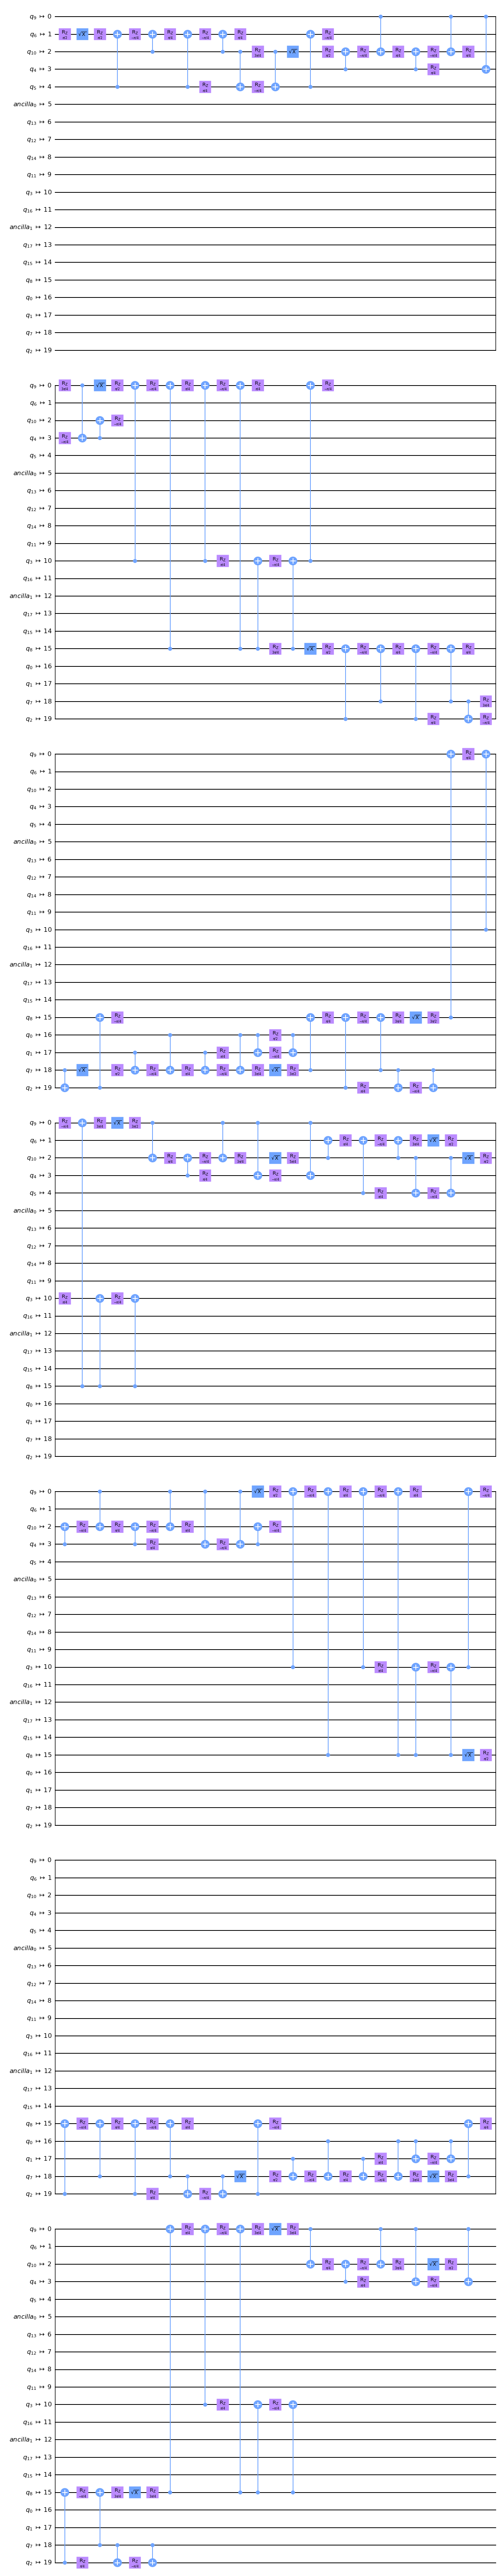

In [35]:
result_lists[0][0].draw(output = 'mpl')

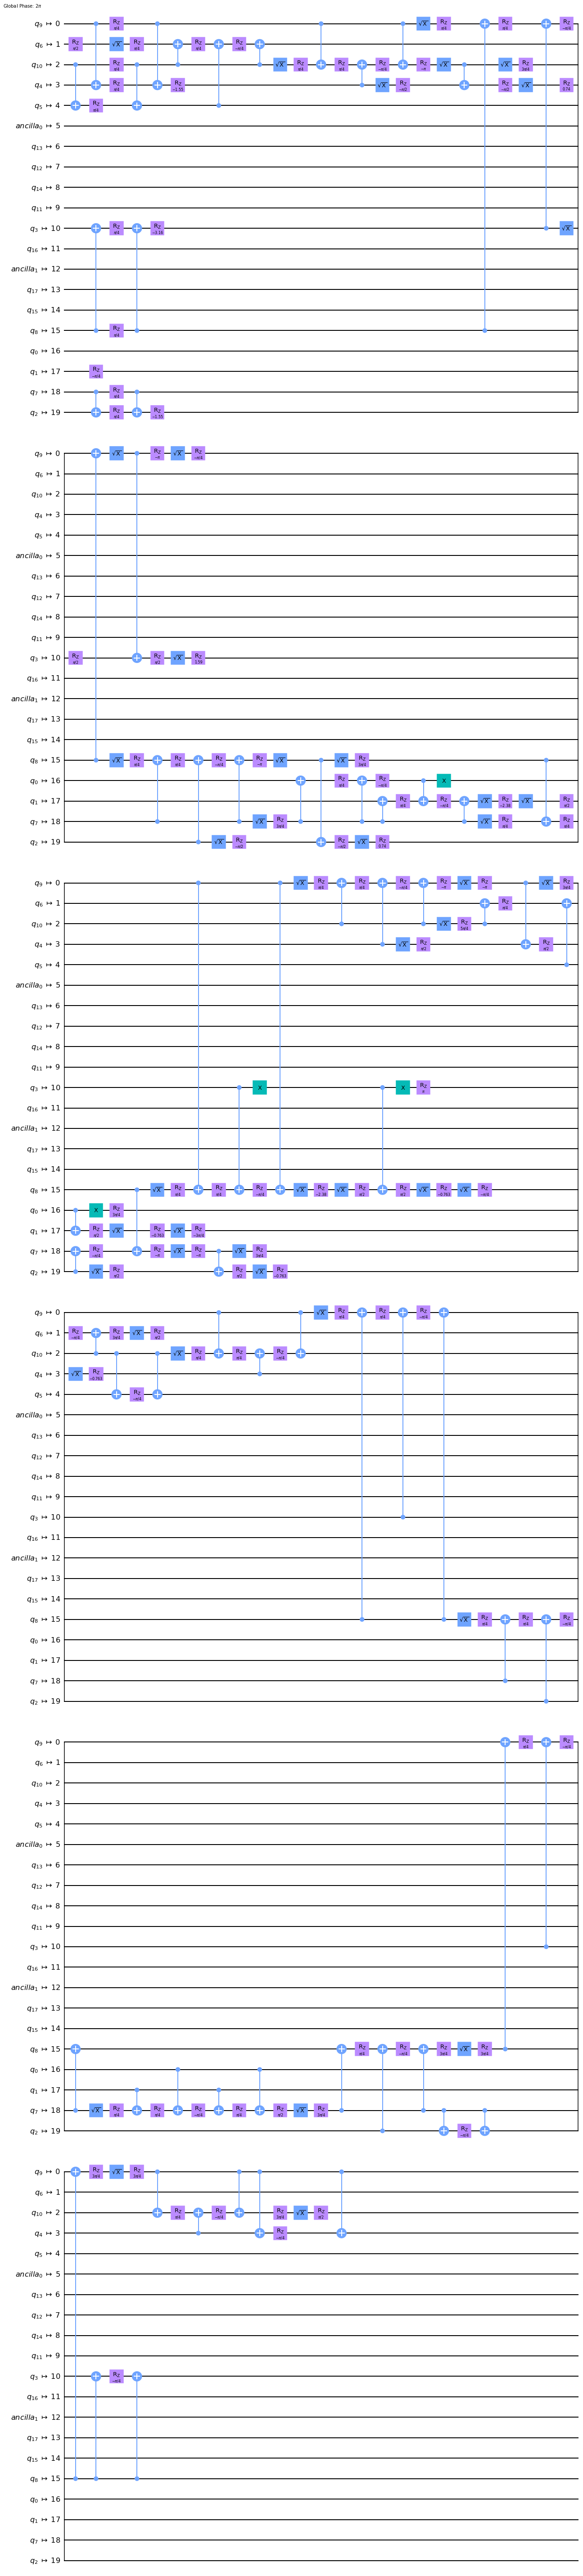

In [36]:
result_lists[0][2].draw(output = 'mpl')

In [97]:
result_lists = generate_results(qc8, pass_manager_config)

layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
No solution found:  nonexistent solution
Layout({
19: Qubit(QuantumRegister(20, 'q'), 0),
18: Qubit(QuantumRegister(20, 'q'), 1),
17: Qubit(QuantumRegister(20, 'q'), 2),
16: Qubit(QuantumRegister(20, 'q'), 3),
14: Qubit(QuantumRegister(20, 'q'), 4),
13: Qubit(QuantumRegister(20, 'q'), 5),
12: Qubit(QuantumRegister(20, 'q'), 6),
11: Qubit(QuantumRegister(20, 'q'), 7),
4: Qubit(QuantumRegister(20, 'q'), 8),
3: Qubit(QuantumRegister(20, 'q'), 9),
2: Qubit(QuantumRegister(20, 'q'), 10),
1: Qubit(QuantumRegister(20, 'q'), 11),
15: Qubit(QuantumRegister(20, 'q'), 12),
10: Qubit(QuantumRegister(20, 'q'), 13),
0: Qubit(QuantumRegister(20, 'q'), 14),
5: Qubit(QuantumRegister(20, 'q'), 15),
9: Qubit(QuantumRegister(20, 'q'), 16),
8: Qubit(QuantumRegister(20, 'q'), 17),
6: Qubit(QuantumRegister(20, 'q'), 18),
7: Qubit(Q

('00', '11', 'b')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('11', '00

No solution found:  nonexistent solution
Layout({
19: Qubit(QuantumRegister(20, 'q'), 0),
18: Qubit(QuantumRegister(20, 'q'), 1),
17: Qubit(QuantumRegister(20, 'q'), 2),
16: Qubit(QuantumRegister(20, 'q'), 3),
14: Qubit(QuantumRegister(20, 'q'), 4),
13: Qubit(QuantumRegister(20, 'q'), 5),
12: Qubit(QuantumRegister(20, 'q'), 6),
11: Qubit(QuantumRegister(20, 'q'), 7),
4: Qubit(QuantumRegister(20, 'q'), 8),
3: Qubit(QuantumRegister(20, 'q'), 9),
2: Qubit(QuantumRegister(20, 'q'), 10),
1: Qubit(QuantumRegister(20, 'q'), 11),
15: Qubit(QuantumRegister(20, 'q'), 12),
10: Qubit(QuantumRegister(20, 'q'), 13),
0: Qubit(QuantumRegister(20, 'q'), 14),
5: Qubit(QuantumRegister(20, 'q'), 15),
9: Qubit(QuantumRegister(20, 'q'), 16),
8: Qubit(QuantumRegister(20, 'q'), 17),
6: Qubit(QuantumRegister(20, 'q'), 18),
7: Qubit(QuantumRegister(20, 'q'), 19)
})
No solution found:  nonexistent solution
Layout({
19: Qubit(QuantumRegister(20, 'q'), 0),
18: Qubit(QuantumRegister(20, 'q'), 1),
17: Qubit(QuantumR

('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 10), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 10)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 10), Qubit(QuantumRegister(20, 'q'), 11)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 12), Qubit(QuantumRegister(20, 'q'), 10)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 12), Qubit(QuantumRegister(20, 'q'), 10)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 10), Qubit(QuantumRegister(20, 'q'), 14)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 11), Qubit(QuantumRegister(20, 'q'), 10)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 11), Qubit(QuantumRegister(20, 'q'), 10)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit

('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 15), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 15)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 15), Qubit(QuantumRegister(20, 'q'), 19)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 15), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'f')
('11', '00', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 15), Qubit(QuantumRegister(20, 'q'), 17)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 18), Qubit(QuantumRegister(20, 'q'), 15)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 18), Qubit(QuantumRegister(20, 'q'), 15)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 17), Qubit(QuantumRegister(20, 'q'), 15)]
('00', '11', 'f')
('11', '00', 'b')

intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 9)]
('00', '11', 'b')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 15), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 15), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 15)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 15), Qubit(QuantumRegister(20, 'q'), 17)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 15), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'f')
('11', '00', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 15), Qubit(QuantumRegister(20, 'q'), 5)]
('00', '11', 'f')
('11', '00', 'f')
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 5), Qubit(QuantumRegister(20, 'q'), 15)]
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(Quant

In [98]:
for i in result_lists:
    print(i.count_ops())
    print(success_rate(i.count_ops()))

OrderedDict([('cx', 841), ('rz', 190), ('x', 43), ('sx', 12)])
0.00019949492040881208
OrderedDict([('rz', 2028), ('sx', 1045), ('acecr_pm', 841), ('x', 575)])
8.620565523591051e-05
OrderedDict([('cx', 841), ('rz', 190), ('x', 43), ('sx', 12)])
0.00019949492040881208
OrderedDict([('rz', 2026), ('sx', 1021), ('acecr_pm', 841), ('x', 339)])
0.00010513163822502623


In [37]:
qc3 = generate_cnx_log_depth(19)
qc3.count_ops()

OrderedDict([('ccx', 17)])

In [54]:
result_lists0 = generate_results(qc0, pass_manager_config)

layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
layout_method:  dense
routing method:  basic
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
Layout({
18: Qubit(QuantumRegister(18, 'q'), 7),
15: Qubit(QuantumRegister(18, 'q'), 8),
0: Qubit(QuantumRegister(18, 'q'), 9),
2: Qubit(QuantumRegister(18, 'q'), 10),
10: Qubit(QuantumRegister(18, 'q'), 3),
16: Qubit(QuantumRegister(18, 'q'), 0),
17: Qubit(QuantumRegister(18, 'q'), 1),
19: Qubit(QuantumRegister(18, 'q'), 2),
3: Qubit(QuantumRegister(18, 'q'), 4),
4: Qubit(QuantumRegister(18, 'q'), 5),
1: Qubit(QuantumRegister(18, 'q'), 6),
9: Qubit(QuantumRegister(18, 'q'), 11),
7: Qubit(QuantumRegister(18, 'q'), 12),
6: Qubit(QuantumRegister(18, 'q'), 13),
8: Qubit(QuantumRegister(18, 'q'), 14),
14: Qubit(QuantumRegister(18, 'q'), 15),
11: Qubit(QuantumRegister(18, 'q'), 16),
13: Qubit(QuantumRegister(18, 'q'), 17)
})
The physical qubits for th

look for variant_rules ('12', '00', 'f', 'p')
final tag, one match ('12', '01', 'f', 's')
look for variant_rules ('12', '00', 'f', 'p')
final tag, one match ('12', '01', 'f', 's')
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
ccx
Layout({
18: Qubit(QuantumRegister(18, 'q'), 7),
15: Qubit(QuantumRegister(18, 'q'), 8),
0: Qubit(QuantumRegister(18, 'q'), 9),
2: Qubit(QuantumRegister(18, 'q'), 10),
10: Qubit(QuantumRegister(18, 'q'), 3),
16: Qubit(QuantumRegister(18, 'q'), 0),
17: Qubit(QuantumRegister(18, 'q'), 1),
19: Qubit(QuantumRegister(18, 'q'), 2),
3: Qubit(QuantumRegister(18, 'q'), 4),
4: Qubit(QuantumRegister(18, 'q'), 5),
1: Qubit(QuantumRegister(18, 'q'), 6),
9: Qubit(QuantumRegister(18, 'q'), 11),
7: Qubit(QuantumRegister(18, 'q'), 12),
6: Qubit(QuantumRegister(18, 'q'), 13),
8: Qubit(QuantumRegister(18, 'q'), 14),
14: Qubit(QuantumRegister(18, 'q'), 15),
11: Qubit(QuantumRegister(18, 'q'), 16),
13: Qubit(QuantumRegister(18, 'q'), 17)
})
The physical qubits for th

('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'b')
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 4)]
intersect [Qubit(QuantumRegister(20, 'q'), 2)]
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 2), Qubit(QuantumRegister(20, 'q'), 1)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 4), Qubit(QuantumRegister(20, 'q'), 1)]
('00', '11', 'f')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 0), Qubit(QuantumRegister(20, 'q'), 2)]
('00', '11', 'b')
('11', '00', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 15)]
('11', '00', 'f')
intersect [Qubit(QuantumRegister(20, 'q'), 15), Qubit(QuantumRegister(20, 'q'), 0)]
('00', '11', 'f')
('11', '00', 'f')
('11', '00', 'f')
('00', '11', 'b')
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 18)]
('00', '11', 'b')
intersect [Qubit(QuantumRegister(20, 'q'), 18), Qubit(QuantumRegister(

In [33]:
def success_rate(op_dict, display = False, total_time = 100, t1 = 70000, t2 = 72000, cx_error = 0.01, cr_error = 0.01, sx_error = 0.0004, x_error = 0.0008, ccx_error = 0.02):
    try:
        sx_count = op_dict['sx']
    except:
        sx_count = 0
    try:
        x_count = op_dict['x']
    except:
        x_count = 0
    try:
        cx_count = op_dict['cx']
    except:
        cx_count = 0
    try:
        cr_count = op_dict['acecr_pm']
    except:
        cr_count = 0
    try:
        ccx_count = op_dict['ccx']
    except:
        ccx_count = 0
    pst = np.exp(- 10 * total_time / t1 - 10 * total_time / t2) * (1 - sx_error) ** sx_count \
    * (1 - x_error) ** x_count * (1 - cx_error) ** cx_count * (1 - ccx_error) ** ccx_count * (1 - cr_error) ** cr_count
    if display == True:
        print("Total Time:{}, T1:{}, T2:{}, success_rate:{}".format(total_time, t1, t2, np.exp(-10 * total_time / t1 - 10 * total_time / t2)))
        print("sx_count:{}, sx_error:{}, sx_success_rate:{}".format(sx_count, sx_error, (1 - sx_error) ** sx_count))
        print("x_count:{}, x_error:{}, x_success_rate:{}".format(x_count, x_error, (1 - x_error) ** x_count))
        print("cx_count:{}, cx_error:{}, cx_success_rate:{}".format(cx_count, cx_error, (1 - cx_error) ** cx_count))
        print("cr_count:{}, cr_error:{}, cr_success_rate:{}".format(cr_count, cr_error, (1 - cr_error) ** cr_count))
        print("ccx_count:{}, ccx_error:{}, ccx_success_rate:{}".format(ccx_count, ccx_error, (1 - ccx_error) ** ccx_count))
    return pst

In [63]:
for i in result_lists0:
    print(i.count_ops())
    pst = success_rate(i.count_ops())
    print(pst)

OrderedDict([('rz', 120), ('cx', 96), ('sx', 18)])
Total Time:100, T1:70000, T2:72000, success_rate:0.97221859952684
sx_count:18, sx_error:0.0004, sx_success_rate:0.9928244278542492
x_count:0, x_error:0.0004, x_success_rate:1.0
cx_count:96, cx_error:0.0147, cx_success_rate:0.24130946001294448
cr_count:0, cr_error:0.0147, cr_success_rate:1.0
ccx_count:0, ccx_error:0.02, ccx_success_rate:1.0
0.23292211625051087
OrderedDict([('rz', 289), ('sx', 189), ('acecr_pm', 96), ('x', 45)])
Total Time:100, T1:70000, T2:72000, success_rate:0.97221859952684
sx_count:189, sx_error:0.0004, sx_success_rate:0.9271729844961487
x_count:45, x_error:0.0004, x_success_rate:0.9821574956417964
cx_count:0, cx_error:0.0147, cx_success_rate:1.0
cr_count:96, cr_error:0.0147, cr_success_rate:0.24130946001294448
ccx_count:0, ccx_error:0.02, ccx_success_rate:1.0
0.21363882339941706
OrderedDict([('rz', 114), ('cx', 74), ('sx', 46), ('x', 4)])
Total Time:100, T1:70000, T2:72000, success_rate:0.97221859952684
sx_count:46,

In [ ]:
pst = success_rate(op_dict)